# Imports and method


In [52]:
from carbontracker import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics
import os
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
#import Models as M
!pip3 install patchify
import patchify as Pf
from PIL import Image
from sklearn.metrics import precision_recall_curve
from datetime import datetime
from torchvision import models
import os
!pip install carbontracker


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
os.chdir(os.getcwd())

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        self.ax.legend
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

In [55]:
# Open the log file for reading
def process_log_files(log_files):
    time_values = []
    energy_values = []
    co2eq_values = []
    for log_file_path in log_files:
        # Open the log file for reading
        with open(log_file_path, 'r') as file:
            read_values = False
            for line in file:
                if 'Actual consumption' in line:
                    read_values = True
                elif read_values and line.strip() != '':
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        label = parts[0].strip()
                        value = parts[1].strip()
                        if label == 'Time:':
                            hours, minutes, seconds = value.split(':')
                            total_seconds = int(hours) * 3600 + int(minutes) * 60 + int(seconds)
                            time_values.append(total_seconds)
                        elif label == 'Energy:':
                            energy = float(value.rstrip(' kWh'))
                            energy_values.append(energy)
                        elif label == 'CO2eq:':
                            co2eq = float(value.rstrip(' g'))
                            co2eq_values.append(co2eq)
                elif 'CarbonTracker: Finished monitoring.' in line:
                    break
    return time_values, energy_values, co2eq_values

In [60]:
def plot_radar(acc_values_1, time_values, energy_values, co2eq_values):
    variables = (r'$P_v$', r'$E(kWh)$', r'$|\theta|(M)$', r'$T(s)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 1), (0, 0.12), (0, 50), (0, 2200)])
    
    for i in range(len(time_values)):
        data = (acc_values_1[i], energy_values[i], co2eq_values[i], time_values[i])
        radar.plot(data, label=f'Data {i+1}', alpha = 0.5)
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')
    plt.title('Variables Comparison')
    plt.show()

# ConvNet DM

Time values: [2174, 2180, 2175]
Energy values: [0.103487, 0.103417, 0.103746]
CO2eq values: [49.156352, 49.122959, 49.279296]


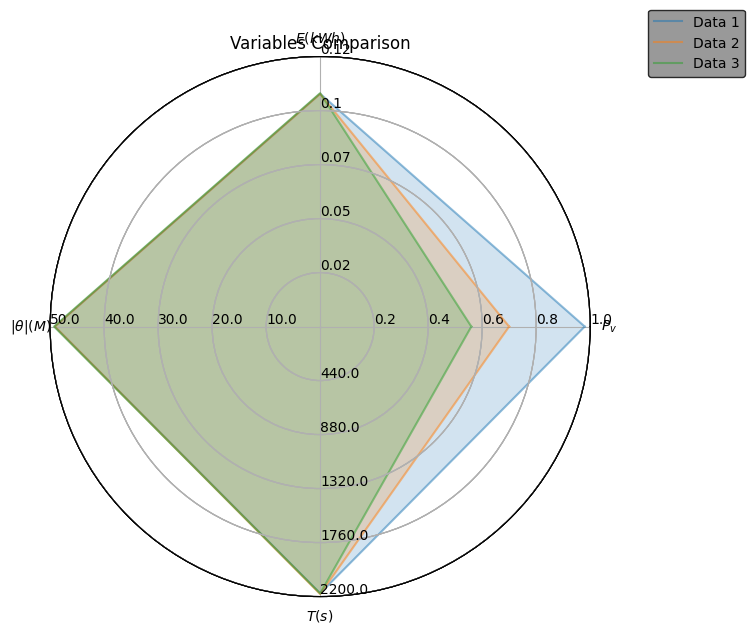

In [61]:
os.chdir(os.getcwd())
path = 'Data/Synthetic_Alzheimer_MRI/CarbonLogs/'
end = '.log'
log_files_test = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_1ConvNet2_5004_2023-05-12T153034Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_2ConvNet2_19428_2023-05-12T144727Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4ConvNet2_9000_2023-05-12T140248Z_carbontracker_output{end}'
                  ]
time_values, energy_values, duration_values = process_log_files(log_files_test)
acc_values_1= [0.98, 0.7, 0.56]
# Print the extracted values
print("Time values:", time_values)
print("Energy values:", energy_values)
print("CO2eq values:", duration_values)

plot_radar(acc_values_1, time_values, energy_values, duration_values)